<a href="https://colab.research.google.com/github/gordoncd/time-series-summer2023/blob/main/time_series_stock_training_wheels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis/Prediction with Keras (training wheels)


First we import dependencies

In [ ]:
import tensorflow
import keras
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
! pip install pandas_ta
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import TimeDistributed
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate


In [ ]:
google = yf.Ticker("GOOGL")
google.history('5y').head()
data = yf.download("GOOGL", '2018-01-01', '2023-01-01')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000


Now we have data, so lets sort out some indicators.

In [ ]:
data['RSI'] = ta.rsi(data.Close, length = 15)
data['EMAF'] = ta.ema(data.Close, length = 20)
data['EMAM'] = ta.ema(data.Close, length = 100)
data['EMAS'] = ta.ema(data.Close, length = 150)
#can add other technical indicators

data['Target'] = data['Adj Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]
data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace = True)
data.reset_index(inplace= True)
data.drop(['Volume', 'Close', 'Date'], axis = 1, inplace = True)

In [ ]:
data_set = data.iloc[:,0:11]
pd.set_option('display.max_columns', None)

In [ ]:
sc = MinMaxScaler(feature_range = (0,1))
data_set_scaled = sc.fit_transform(data_set)

In [ ]:
X = []

backcandles = 30
for j in range(8):
  X.append([])
  for i in range(backcandles, data_set_scaled.shape[0]):
    X[j].append(data_set_scaled[i-backcandles:i,j])

X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(data_set_scaled[backcandles:,-3])

y=np.reshape(yi,(len(yi),1))
#shape very important here


Now we can split data into train/test splits


In [ ]:
split_thresh = int(len(X)*.8)
print(split_thresh)

X_train, X_test = X[:split_thresh], X[split_thresh:]
y_train, y_test = y[:split_thresh], y[split_thresh:]

863


In [ ]:
lstm_size = 150
batch_size = 15
epochs = 30
hyperparams = [lstm_size, batch_size, epochs]

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(hyperparams[0], name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=hyperparams[1], epochs=hyperparams[2], shuffle=True, validation_split = 0.1)

Epoch 1/30
52/52 [==============================] - 3s 20ms/step - loss: 0.0346 - val_loss: 0.0279
Epoch 2/30
52/52 [==============================] - 0s 8ms/step - loss: 0.0080 - val_loss: 0.0227
Epoch 3/30
52/52 [==============================] - 1s 10ms/step - loss: 0.0059 - val_loss: 0.0230
Epoch 4/30
52/52 [==============================] - 1s 11ms/step - loss: 0.0056 - val_loss: 0.0231
Epoch 5/30
52/52 [==============================] - 0s 9ms/step - loss: 0.0058 - val_loss: 0.0242
Epoch 6/30
52/52 [==============================] - 1s 12ms/step - loss: 0.0055 - val_loss: 0.0363
Epoch 7/30
52/52 [==============================] - 0s 10ms/step - loss: 0.0062 - val_loss: 0.0226
Epoch 8/30
52/52 [==============================] - 1s 11ms/step - loss: 0.0056 - val_loss: 0.0235
Epoch 9/30
52/52 [==============================] - 1s 12ms/step - loss: 0.0054 - val_loss: 0.0268
Epoch 10/30
52/52 [==============================] - 1s 12ms/step - loss: 0.0062 - val_loss: 0.0230
Epoch 11/30

In [ ]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

7/7 [==============================] - 1s 3ms/step
[0.4465348] [0.17969777]
[0.44819367] [1.]
[0.4500866] [0.52511772]
[0.44362754] [0.60156497]
[0.439215] [0.40521488]
[0.43871945] [0.45809151]
[0.44034702] [0.31528006]
[0.4407605] [0.39103028]
[0.4415775] [0.10676166]
[0.44542527] [0.52143259]


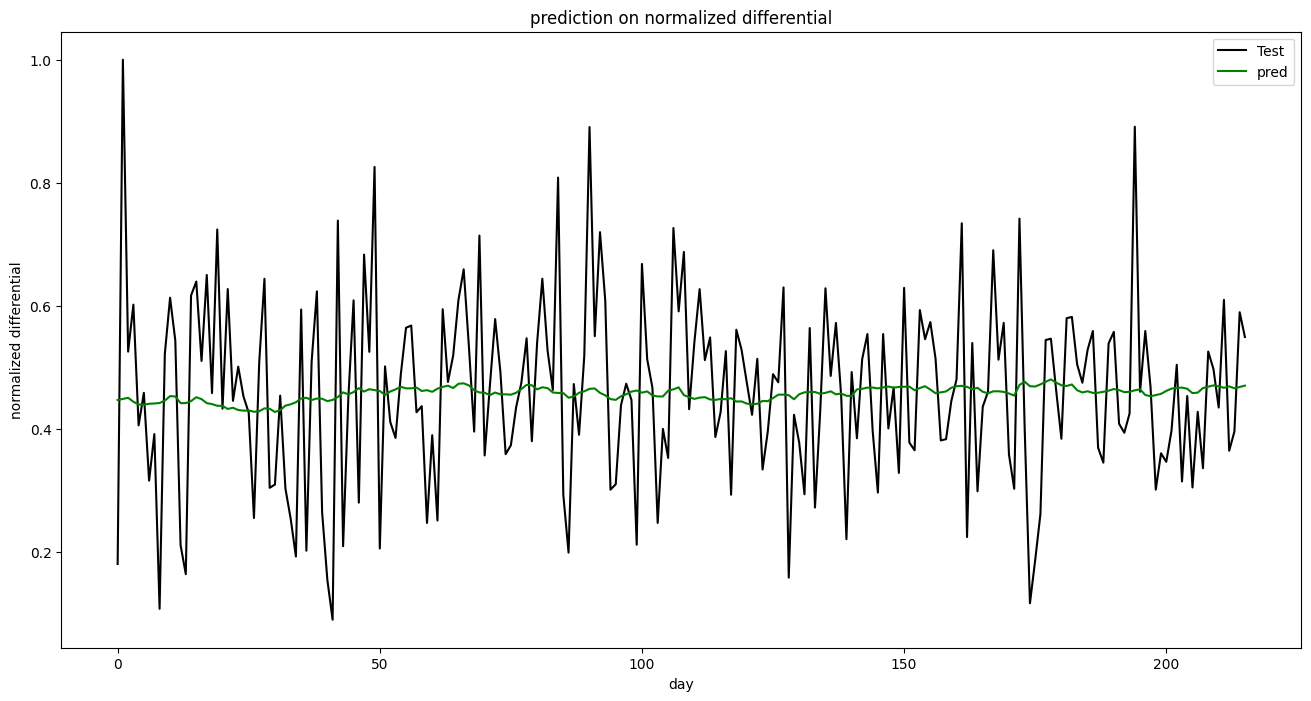

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.xlabel('day')
plt.ylabel('normalized differential')
plt.title('prediction on normalized differential')
plt.legend()
plt.show()